The goal of the Titanic competition is to predict who survived the disaster based on some information about the individual. The competition is described at https://www.kaggle.com/c/titanic/overview

__Data Dictionary__
- Survival: 0 = No, 1 = Yes
- Pclass: Ticket class,, 1st = Upper 2nd = Middle 3rd = Lower
- Sex: sex of the individual
- Age: age in years
- SibSp: The # of siblings / spouses aboard the Titanic Sibling = brother, sister, stepbrother, stepsister Spouse = husband, wife (mistresses and fiancés were ignored)
- Parch: The # of parents / children aboard the Titanic Parent = mother, father Child = daughter, son, stepdaughter, stepson Some children travelled only with a nanny, therefore parch=0 for them.
- Ticket: Ticket number
- Fare: Passenger fare
- Cabin: Cabin number embarked
- Port of Embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

In [1208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter 
import scipy.stats as stats
import string
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

Loaded the train and test data into pandas data frame. Both the train and test data contain missing values. Train has is missing 177 age values, 687 cabin values and 2 embarked values. Test data is missing 86 age values, 1 fare value and 327 cabin values. The missing values will either need to be imputed (filled in based on training set data) or the rows will need to be removed. Used describe to look into the statistics of the numeric columns. No obvious outliers are observed in the data. 

In [1209]:
target_column = ['Survived']
# load in the csv files
test = pd.read_csv('data_files/test.csv')
train = pd.read_csv('data_files/train.csv')

Check_nans return a data frame with percentage missing calculated for the test and train dataframe. 

In [1210]:
def check_nans(train_df, test_df):
    train_nan = train_df.isna().sum() / len(train_df) * 100
    train_nan.sort_values(inplace=True, ascending=False)
    test_nan = test_df.isna().sum() / len(test_df) * 100
    test_nan.sort_values(inplace=True, ascending=False)
    return_df = pd.concat([train_nan, test_nan], axis=1)
    return_df.columns = ['Train', 'Test']
    return return_df

In [1211]:
print(check_nans(train, test))

                 Train       Test
Cabin        77.104377  78.229665
Age          19.865320  20.574163
Embarked      0.224467   0.000000
Fare          0.000000   0.239234
Ticket        0.000000   0.000000
Parch         0.000000   0.000000
SibSp         0.000000   0.000000
Sex           0.000000   0.000000
Name          0.000000   0.000000
Pclass        0.000000   0.000000
Survived      0.000000        NaN
PassengerId   0.000000   0.000000


In [1212]:
print('\nDescribe train data')
print(train.describe())
print('\nDescribe test data')
print(test.describe())


Describe train data
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  

Describe test data
       PassengerId      Pclass         A

## Check for invalid values

Created a function to check to see if any of the rows has invalid values (values that should not exist based on the data definition above). 

In [1213]:
target_column = 'Survived'

# replace NaNs in the train and test dataframes with the missing value
#train.fillna(missing_value, inplace=True)
#test.fillna(missing_value, inplace=True)

check_values_dict = {'Survived':[0, 1], 
                     'Pclass':[1, 2, 3], 
                     'Sex':['male', 'female'],
                     'Embarked':['C', 'Q', 'S']}

def check_values(df, check_dict):
    return_dict = {}
    for (key, value) in check_dict.items():
        # check if the column exists in pandas
        if key in df.columns:
            # check column and see if there is any invalid values
            temp_bool_series = ~df.loc[~df[key].isnull(), key].isin(value)
            # if invalid values exist for the column. Store the row indices in dictionary
            if temp_bool_series.sum() > 0:
                return_dict[key] = temp_bool_series[temp_bool_series].index
        else:
            print('Column: ' + key + ' does not exist')
    return return_dict

def print_rows_with_invalid(df, invalid_dict):
    for (key, value) in invalid_dict.items():
        print(key + ' is invalid in the following rows')
        print(df.iloc[value])

print('Check if train has any invalid values')
print_rows_with_invalid(train, check_values(train, check_values_dict))
print('Check if test has any invalid values')
print_rows_with_invalid(test, check_values(test, check_values_dict))


Check if train has any invalid values
Check if test has any invalid values
Column: Survived does not exist


## Feature conversion encoding

For most machine learning algorithms, all features must be represented as numbers. Sex is encoded into integers. 

In [1214]:
def encode_sex(df):
    df['Sex'] = (df['Sex'].str.lower() == 'male').astype(int)
    return df

train = encode_sex(train)
test = encode_sex(test)

Last name may contain useful information because families may have been more likely to survive or perish together. Following function extracts the last name and title. Last name is assumed to be to the left of the comma. The title may give a hint about age and it is assummed to be between the comma and period. Both are converted to lower case to handle if same word was capitalized differntly in different records.

In [1215]:
def parse_name(df):
    split_name_at_comma = df['Name'].str.split(',', n=1, expand=True)
    df['LastName'] = split_name_at_comma.get(0).str.lower()
    split_name_at_period = split_name_at_comma.get(1).str.split('.', n=1, expand=True)
    df['Title'] = split_name_at_period.get(0).str.lower().str.strip()
    df.drop('Name', axis=1, inplace=True)
    return df

# extract name and title
train = parse_name(train)
test = parse_name(test)

Ticket column contains letters and numbers. The column will be broken up into letters and numbers. For the text porition of the ticket number, the string is converted to lower case and the punctuation is stripped from the string. 

In [1216]:
# create dictionary of punctuation to remove
punctuation_table = str.maketrans(dict.fromkeys(string.punctuation))

def parse_ticket(df, punctuation_table):
    # split ticket at the first space
    split_ticket_at_space = df['Ticket'].str.split(' ', n=1, expand=True)
    # convert to lower case and remove the punctuation
    temp = split_ticket_at_space.get(0).str.lower().str.translate(punctuation_table)
    df['TicketHeader'] = temp[~temp.str.isnumeric()]
    df['TicketNumber'] = temp[temp.str.isnumeric()]
    df.loc[~temp.str.isnumeric(), 'TicketNumber'] = split_ticket_at_space.get(1)
    df['TicketNumber'] = df['TicketNumber'].astype('int64')
    return df

def extract_numbers_text(df, col):
    # Extract letters from the col, combine into one string and convert to lower case
    df[col + 'Letters'] = df[col].str.findall(r'[A-Za-z]+').str.join('').str.lower()
    # Extract numbers from the col, combine to one string, replace empty strings with NaNs and convert to numeric
    df[col + 'Numbers'] = pd.to_numeric(df[col].str.findall(r'[0-9]+').str.join('').replace('', np.nan))
    #df.drop(col, axis=1, inplace=True)
    return df
    

train = extract_numbers_text(train, 'Ticket')
test = extract_numbers_text(test, 'Ticket')

train = extract_numbers_text(train, 'Cabin')
test = extract_numbers_text(test, 'Cabin')

Some individuals have multiple cabins. For example, cabin = 'C1 C2 C3' would lead to an extracted text = 'ccc'. The following function extracts only the unique characters. For the example above, the extracted text would become 'c'.

In [1217]:
def create_set_string(string):
    if type(string) == str:
        string = ''.join(sorted(list(set(string))))
    return string
 
train['CabinLetters'] = train['CabinLetters'].apply(create_set_string)
test['CabinLetters'] = test['CabinLetters'].apply(create_set_string)

Calculate the percentage of records in the train and tet dataframes.

In [1218]:
def calc_percent_records(train_df, test_df,  col):
    train_per = train_df[col].value_counts(dropna=False)/len(train_df)*100
    test_per = test_df[col].value_counts(dropna=False)/len(test_df)*100
    out_df = pd.concat([train_per, test_per], axis=1)
    out_df.columns = ['Train', 'Test']
    return out_df

Looked at the percentage of people that were on the different decks. The percentage is low for all decks, which means the deck must be imputed from the other features in order for this to be a useful feature. 

In [1219]:
print(calc_percent_records(train, test, 'CabinLetters'))

         Train       Test
NaN  77.104377  78.229665
c     6.621773   8.373206
b     5.274972   4.306220
d     3.703704   3.110048
e     3.591470   2.153110
a     1.683502   1.674641
f     1.010101   1.196172
g     0.448934   0.239234
fg    0.336700   0.239234
t     0.112233        NaN
ef    0.112233   0.478469


## Impute Missing Data

The columns age, cabin, embarked and fare have NaN values. Exploratory data anlysis is performed to see the correlation between parameters with goal of using a different parameter to guess what the missing value should be.

Train has is missing 177 age values, 687 cabin values and 2 embarked values. Test data is missing 86 age values, 1 fare value and 327 cabin values.



### Fare 

Fare and Pclass should be correlated. Higher fare with better class (lower number). Histogram was created to look for the correlation. Pclass = 1 has higher ticket price than Pclass = 2 and 3. The fare is non gaussin for the different Pclasses

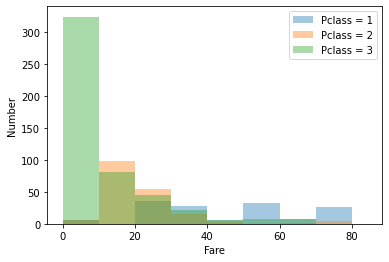

In [1220]:
def multi_hist(df, value_col, hue_col, bins):
    unique_values = sorted(df[hue_col].unique())
    for value in unique_values:
        selected_entries = df[df[hue_col] == value]
        label = hue_col + ' = '+ str(value)
        sns.distplot(selected_entries[value_col].dropna(),  kde=False, label=label, bins=bins)
    plt.legend()
    plt.xlabel(value_col)
    plt.ylabel('Number')
    plt.show()
    return None

bins = np.arange(0, 90, 10)
multi_hist(train, 'Fare', 'Pclass', bins=bins)
#Note: There is a new function called sns.histogram that should be released soon which will do the above better

A function is created to look at the emperical cummulative distribution function (ECDF). ECDF is another way to look at the distribution of the data. From the ECDF, there is large difference in the distribution for fare of pclass = 1 and the other pclasses. The difference between pclass = 2 and pclass = 3 is small. 

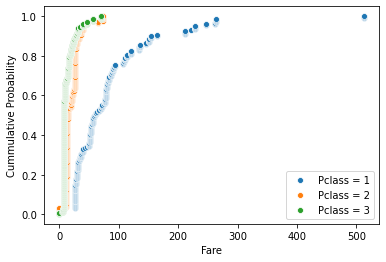

             mean   median        std  min       max  count
Pclass                                                     
1       84.154687  60.2875  78.380373  0.0  512.3292    216
2       20.662183  14.2500  13.417399  0.0   73.5000    184
3       13.675550   8.0500  11.778142  0.0   69.5500    491


In [1221]:
def multi_ecdf(df, value_col, hue_col):
    unique_values = sorted(df[hue_col].dropna().unique())
    for value in unique_values:
        selected_entries = df[df[hue_col] == value]
        label = hue_col + ' = '+ str(value)
        """ Compute ECDF """
        x = np.sort(selected_entries[value_col].dropna())
        n = x.size
        y = np.arange(1, n+1) / n
        sns.scatterplot(x, y, label=label)
    plt.legend()
    plt.xlabel(value_col)
    plt.ylabel('Cummulative Probability')
    plt.show()
    return None

multi_ecdf(train, 'Fare', 'Pclass')

print(train.groupby('Pclass')['Fare'].agg([np.mean, np.median, np.std, 'min', 'max', 'count']))

The missing fare will be imputed by using the median fare from train for the given pclass. Additionally, fares of 0 will be considered missing. This reduces the impact of the outliers observed in Pclass = 1.

In [1222]:
train['Fare'] = train['Fare'].replace(0, np.nan)
test['Fare'] = test['Fare'].replace(0, np.nan)

def impute_fare(train, test):
    median_fare_by_class = train.groupby('Pclass')['Fare'].agg(np.median).round(2)
    for p_class in median_fare_by_class.index:
        mask_train = train['Fare'].isna() & (train['Pclass'] == p_class)
        mask_test = test['Fare'].isna() & (test['Pclass'] == p_class)
        train.loc[mask_train, 'Fare'] = median_fare_by_class[p_class]
        test.loc[mask_test, 'Fare'] = median_fare_by_class[p_class]
    return train, test

train, test = impute_fare(train, test)

### Age

Age may be correlated with the title of the person (ex. Mr., Mrs., ....). In order to determine this, histograms were created for the different titles. Before creating the historam any title with very low percentage is merged into a new category callled other. 

In [1223]:
print(calc_percent_records(train, test, 'Title'))

                  Train       Test
mr            58.024691  57.416268
miss          20.426487  18.660287
mrs           14.029181  17.224880
master         4.489338   5.023923
dr             0.785634   0.239234
rev            0.673401   0.478469
col            0.224467   0.478469
major          0.224467        NaN
mlle           0.224467        NaN
ms             0.112233   0.239234
capt           0.112233        NaN
mme            0.112233        NaN
jonkheer       0.112233        NaN
the countess   0.112233        NaN
lady           0.112233        NaN
sir            0.112233        NaN
don            0.112233        NaN
dona                NaN   0.239234


Some of the titles are used very infrequently. Those titles will not be useful for training. The following function will merge titles with low frequency into a new title called other.

In [1224]:
def merge_values(df, col, threshold, new_value):
    value_precent = df[col].value_counts() / df[col].value_counts().sum() * 100
    merge_index = value_precent[value_precent < threshold].index
    df.loc[df[col].isin(merge_index), col] = new_value
    return df

In [1225]:
train = merge_values(train, 'Title', 4, 'other')
test = merge_values(test, 'Title', 4, 'other')
print(calc_percent_records(train, test, 'Title'))

            Train       Test
mr      58.024691  57.416268
miss    20.426487  18.660287
mrs     14.029181  17.224880
master   4.489338   5.023923
other    3.030303   1.674641


Create an ECDF on the age to better determine if a title can be used to impute age. 

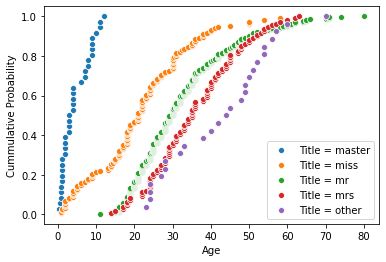

In [1226]:
multi_ecdf(train, 'Age', 'Title')

In [1227]:
print(train.groupby('Title')['Age'].agg([np.mean, np.median, np.std, 'min', 'max', 'count']))

             mean  median        std    min   max  count
Title                                                   
master   4.574167     3.5   3.619872   0.42  12.0     36
miss    21.773973    21.0  12.990292   0.75  63.0    146
mr      32.368090    30.0  12.708793  11.00  80.0    398
mrs     35.898148    35.0  11.433628  14.00  63.0    108
other   42.384615    44.5  13.200233  23.00  70.0     26


Master is a good way to determine if a male is less than 10 years old. However, miss cannot be used by itself because it has a wide distribution. Looked at other variables can be used to determine if a miss is less than 10 years old.  The other two variables that may be helpful is Parch (# of parents and children on board) and SibSp (the number of siblings or spuses on board).

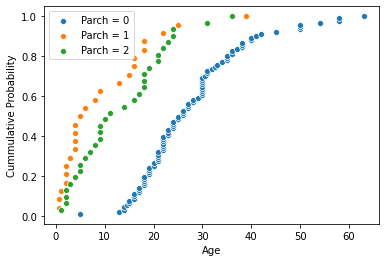

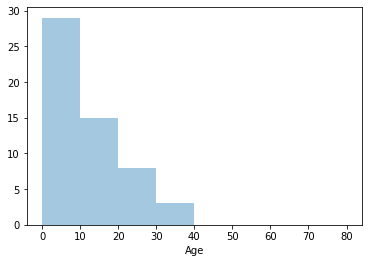

In [1228]:
multi_ecdf(train[train['Title'] == 'miss'], 'Age', 'Parch')
mask = (train['Title'] == 'miss') & (train['Parch'].isin([1, 2]))
sns.distplot(train[mask]['Age'].dropna(),  kde=False, bins=np.arange(0, 90, 10))
plt.show()

If the miss has at least one parent, she is likely less than 20 years old.

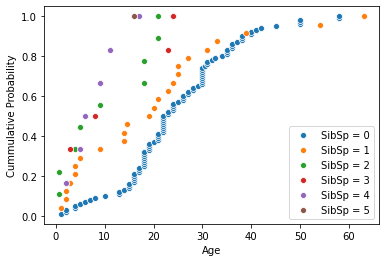

In [1229]:
multi_ecdf(train[train['Title'] == 'miss'], 'Age', 'SibSp')

The amount of sibling does not seem to be a good metric. There are individuals with no siblings that are less than 10 years. During the titanic disaster, women and children were the first ones on the lifeboats. Therefore, I will create a new feature called child. This feature is to capture any individual that is less than 10 years old. If the age is blank, it will assume that all individuals with the title master and miss with at least one parent is also a child.

In [1230]:
def encode_child(df, age):
    df['Child'] = 0
    age_mask = (df['Age'] <= age)
    master_mask = (df['Title'] == 'master')
    miss_mask = (train['Title'] == 'miss') & (train['Parch'].isin([1, 2]))
    df.loc[(age_mask | master_mask | miss_mask),'Child'] = 1
    return df

train = encode_child(train, 10)
test = encode_child(test, 10)


print(train['Child'].value_counts())
print(test['Child'].value_counts())

0    786
1    105
Name: Child, dtype: int64
0    361
1     57
Name: Child, dtype: int64


Group age by decade and look at the survival rate for the different groups.

In [1231]:
train['AgeDecade'] = (train['Age'] / 10).apply(np.floor)
trained_grouped_by_age_decade = train.groupby('AgeDecade')
print(trained_grouped_by_age_decade['Survived'].agg([np.mean, 'count']))

               mean  count
AgeDecade                 
0.0        0.612903     62
1.0        0.401961    102
2.0        0.350000    220
3.0        0.437126    167
4.0        0.382022     89
5.0        0.416667     48
6.0        0.315789     19
7.0        0.000000      6
8.0        1.000000      1


Only indiviudals less than 10 years old have significantly different survival rate compared to the other age groups. This age group is covered by the new feature called Child. Age will be dropped because it has little effect on the survival rate and it cannot be imputed by the other features.

In [1232]:
train.drop(['Age', 'AgeDecade'], axis=1, inplace=True)
test.drop('Age', axis=1, inplace=True)

### Cabin ###

Check if ticket number can be used to fill in cabin. People with the same ticket number should be in the same cabin.

In [1233]:
# list of ticket numbers that have a not null cabin
ticket_numbers_not_null = train[train['Cabin'].notnull()]['TicketNumbers'].unique()
# list of ticket numbers that have a null cabin
ticket_numbers_null = train[train['Cabin'].isna()]['TicketNumbers'].unique()
# create a list of ticket numbers with at least one nul value and one not null value
common_ticket_numbers = sorted(list(set(ticket_numbers_not_null) & set(ticket_numbers_null)))
print(len(common_ticket_numbers))
print(common_ticket_numbers)
print(train[train['TicketNumbers'] == 113781])

10
[3.0, 2668.0, 17421.0, 17755.0, 17757.0, 17760.0, 17761.0, 19877.0, 36928.0, 113781.0]
     PassengerId  Survived  Pclass  Sex  SibSp  Parch  Ticket    Fare  \
297          298         0       1    0      1      2  113781  151.55   
305          306         1       1    1      1      2  113781  151.55   
498          499         0       1    0      1      2  113781  151.55   
708          709         1       1    0      0      0  113781  151.55   

       Cabin Embarked LastName   Title TicketLetters  TicketNumbers  \
297  C22 C26        S  allison    miss                     113781.0   
305  C22 C26        S  allison  master                     113781.0   
498  C22 C26        S  allison     mrs                     113781.0   
708      NaN        S  cleaver    miss                     113781.0   

    CabinLetters  CabinNumbers  Child  
297            c        2226.0      1  
305            c        2226.0      1  
498            c        2226.0      0  
708          NaN           N

Unfortunately, only 10 ticket numbers have at least one null and at least one not null value. Looking at some of the entries, those tickets are sold to people with different last name. Therefore, cabin cannot be imputed from ticket number.

Check if last name can be used to fill in cabin. It is likely that people with the same last night will be in the same cabin.

In [1234]:
# list of ticket numbers that have a not null cabin
last_name_numbers_not_null = train[train['Cabin'].notnull()]['LastName'].unique()
# list of ticket numbers that have a null cabin
last_name_numbers_null = train[train['Cabin'].isna()]['LastName'].unique()
# create a list of ticket numbers with at least one nul value and one not null value
common_last_name = sorted(list(set(last_name_numbers_not_null) & set(last_name_numbers_null)))
print(len(common_last_name))
print(common_last_name)
print(train[train['LastName'] == 'carter'])

14
['allen', 'brown', 'carlsson', 'carter', 'daly', 'flynn', 'harper', 'harris', 'hoyt', 'keane', 'peter', 'smith', 'webber', 'wick']
     PassengerId  Survived  Pclass  Sex  SibSp  Parch  Ticket   Fare    Cabin  \
249          250         0       2    1      1      0  244252   26.0      NaN   
390          391         1       1    1      1      2  113760  120.0  B96 B98   
435          436         1       1    0      1      2  113760  120.0  B96 B98   
763          764         1       1    0      1      2  113760  120.0  B96 B98   
802          803         1       1    1      1      2  113760  120.0  B96 B98   
854          855         0       2    0      1      0  244252   26.0      NaN   

    Embarked LastName   Title TicketLetters  TicketNumbers CabinLetters  \
249        S   carter   other                     244252.0          NaN   
390        S   carter      mr                     113760.0            b   
435        S   carter    miss                     113760.0            b  

Unfortunately, only 14 last names have at least one null and at least one not null value. Looking at some of the entries, those last names correspond to tickets with very different fares and classes. Therfore, last name cannot be used to determine cabin.

Next, investigate if there is a relationship between the Pclass and the cabin deck.

In [1235]:
print(pd.crosstab(train['CabinLetters'], train['Pclass'], rownames=['Cabin Deck'], colnames=['Pclass']))

Pclass       1  2  3
Cabin Deck          
a           15  0  0
b           47  0  0
c           59  0  0
d           29  4  0
e           25  4  3
ef           0  0  1
f            0  8  1
fg           0  0  3
g            0  0  4
t            1  0  0


Only first class passengers were on decks A, B and C. Decks D and E were mostly first class passengers. The other decks were mostly second or third class passengers.

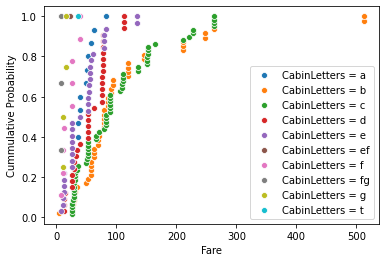

                    mean    median         std      min       max  count
CabinLetters                                                            
a              43.755887  39.60000   15.112007  26.0000   81.8583     15
b             116.143211  80.00000  107.214675   5.0000  512.3292     47
c             100.151341  83.47500   70.225588  26.5500  263.0000     59
d              57.244576  53.10000   29.592832  12.8750  113.2750     33
e              46.026694  45.18125   32.608315   8.0500  134.5000     32
ef             22.358300  22.35830         NaN  22.3583   22.3583      1
f              21.972222  26.00000   12.116907   7.7500   39.0000      9
fg              7.650000   7.65000    0.000000   7.6500    7.6500      3
g              13.581250  13.58125    3.601222  10.4625   16.7000      4
t              35.500000  35.50000         NaN  35.5000   35.5000      1


In [1236]:
multi_ecdf(train, 'Fare', 'CabinLetters')
print(train.groupby(by='CabinLetters')['Fare'].agg([np.mean, np.median, np.std, 'min', 'max', 'count']))

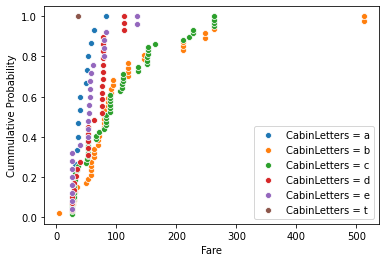

                    mean  median         std      min       max  count
CabinLetters                                                          
a              43.755887  39.600   15.112007  26.0000   81.8583     15
b             116.143211  80.000  107.214675   5.0000  512.3292     47
c             100.151341  83.475   70.225588  26.5500  263.0000     59
d              63.324286  75.250   26.172260  25.9292  113.2750     29
e              55.740168  55.000   30.386910  25.5875  134.5000     25
t              35.500000  35.500         NaN  35.5000   35.5000      1


In [1237]:
multi_ecdf(train[train['Pclass'].isin([1])], 'Fare', 'CabinLetters')
print(train[train['Pclass'].isin([1])].groupby(by='CabinLetters'
                                              )['Fare'].agg([np.mean, np.median, np.std, 'min', 'max', 'count']))

There appears to be no way to easily impute the cabin from the other data that should correlate with it. Therefore, cabin and cabin letters will be dropped.

In [1238]:
train.drop(['Cabin', 'CabinLetters', 'CabinNumbers'], axis=1, inplace=True)
test.drop(['Cabin', 'CabinLetters', 'CabinNumbers'], axis=1, inplace=True)

### Embarked ###

Embarktation port is unlikely to be correlated with any other parameter. Missing values will be replaced with the most common values.

In [1239]:
embark_mode = train['Embarked'].mode()[0]
train['Embarked'].fillna(embark_mode, inplace=True)
test['Embarked'].fillna(embark_mode, inplace=True)

For most machine learing algorithms, the data needs to be encoded as numbers. The following code encodes the location where the person embarked. 

In [1240]:
dict_encode_embarked = {'C':0, 'Q':1, 'S':2}
train['Embarked'].replace(dict_encode_embarked, inplace=True)
test['Embarked'].replace(dict_encode_embarked, inplace=True)

### Fare Encoding ###

Plot the ECDF of the fare column.

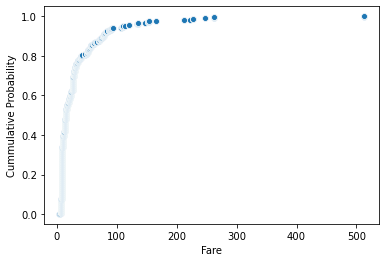

In [1241]:
def ecdf(df, value_col):
    x = np.sort(df[value_col].dropna())
    n = x.size
    y = np.arange(1, n+1) / n
    sns.scatterplot(x, y)
    plt.xlabel(value_col)
    plt.ylabel('Cummulative Probability')
    plt.show()
    return None

ecdf(train, 'Fare')

The fares have a long tail and are spread out. Will break up the fares into 10 separate categories of approximately the same size.

In [1242]:
def determine_boundaries(df, col, numb_cats):
    vals = np.sort(df[col].to_numpy())
    numb_per_cat = len(vals) // numb_cats
    mod = len(vals) % numb_cats
    # create index array. Spread out the mod so that last bucket is not 
    # significantly larger than other buckets
    indexes = np.arange(0, len(vals)+1, numb_per_cat)
    mod_corr = np.zeros(numb_cats+1)
    mod_corr[0:mod+1] = np.arange(0, mod+1)
    mod_corr[mod+1:] = mod_corr[mod]
    # correct for 0 indexing
    indexes =  indexes + mod_corr - np.ones(numb_cats+1)
    indexes[0] = 0
    indexes = indexes.astype(int)
    return vals[indexes]

boundaries = determine_boundaries(train, 'Fare', 10)
print(boundaries)

[  4.0125   7.7375   7.8958   8.05    11.2417  14.5     23.      27.7208
  41.5792  77.9583 512.3292]


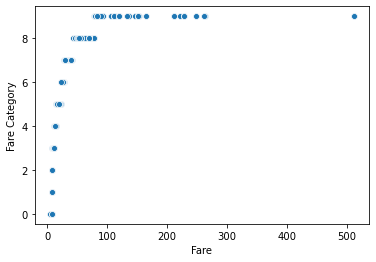

[  4.0125   7.7375   7.8958   8.05    11.2417  14.5     23.      27.7208
  41.5792  77.9583 512.3292]


In [1243]:
numb_cats= 10
train['FareCats'], bins = pd.qcut(train['Fare'], numb_cats, retbins=True, labels=np.arange(0,numb_cats))
sns.scatterplot(train['Fare'], train['FareCats'])
plt.xlabel('Fare')
plt.ylabel('Fare Category')
plt.show()
print(bins)

Use the bins from train to encode the test data.

1    65
4    48
0    47
8    45
5    45
9    44
6    40
3    31
7    30
2    23
Name: FareCats, dtype: int64


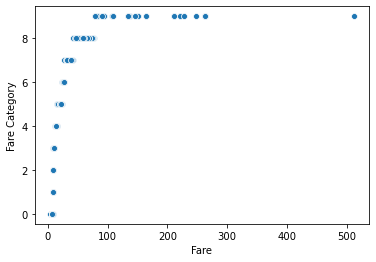

[  0.       7.7375   7.8958   8.05    11.2417  14.5     23.      27.7208
  41.5792  77.9583 512.3292]


In [1244]:
# ensure that all fares are encoded
bins[0] = 0

test['FareCats'], bins = pd.cut(test['Fare'], bins=bins, retbins=True, labels=np.arange(0,numb_cats))
print(test['FareCats'].value_counts())
sns.scatterplot(test['Fare'], test['FareCats'])
plt.xlabel('Fare')
plt.ylabel('Fare Category')
plt.show()
print(bins)

Check to see if the fare categories have an impact on the survival rate.

In [1245]:
print(train.groupby('FareCats')['Survived'].agg(np.mean))

FareCats
0    0.177778
1    0.228814
2    0.227273
3    0.273810
4    0.375000
5    0.456522
6    0.465116
7    0.388889
8    0.500000
9    0.758621
Name: Survived, dtype: float64


This looks like a good feature. Drop fare because it is redundant and convert FareCats into numbers.

In [1246]:
train.drop('Fare', inplace=True, axis=1)
test.drop('Fare', inplace=True, axis=1)
train['FareCats'] = train['FareCats'].astype(int)
test['FareCats'] = test['FareCats'].astype(int)

# Feature Checking #

Determine which features have too few common entries to be useful by looking at the percentage of entries that contained the most common value. Also looked at the percentage entries that had the least common value to determine if any of the entries should be merged. 

In [1247]:
def common_percent(df):
    ret_pd = pd.DataFrame(columns=['Column', 'MostCommonValue', 'MCV_Percent', 'LeastCommonValue', 'LCV_Percent'])
    for col in df.columns:
        value_counts = df[col].replace('', np.nan, regex=True).dropna().value_counts()
        ret_pd = ret_pd.append({'Column': col,
                                'MostCommonValue': value_counts.index[0],
                                'MCV_Percent': value_counts.iloc[0]/len(df)*100,
                                'LeastCommonValue': value_counts.index[-1],
                                'LCV_Percent': value_counts.iloc[-1]/len(df)*100},
                               ignore_index=True)
        
    return ret_pd.sort_values(by=['MCV_Percent', 'LCV_Percent'])

print('Train')
print(common_percent(train))

print('Test')
print(common_percent(train))

Train
           Column MostCommonValue  MCV_Percent LeastCommonValue  LCV_Percent
0     PassengerId             891     0.112233                1     0.112233
6          Ticket            1601     0.785634           315086     0.112233
11  TicketNumbers            2343     0.785634           348124     0.112233
8        LastName       andersson     1.010101            novel     0.112233
10  TicketLetters              pc     6.734007              sop     0.112233
13       FareCats               1    13.243547                2     7.407407
2          Pclass               3    55.106622                2    20.650954
9           Title              mr    58.024691            other     3.030303
1        Survived               0    61.616162                1    38.383838
3             Sex               1    64.758698                0    35.241302
4           SibSp               0    68.237935                5     0.561167
7        Embarked               2    72.502806                1     8.

Ticket, TicketLetters, TicketNumbers and LastName have entries with very low incidence. Therefore, they will be dropped.

Title will be dropped becuase it was used to include the feature Child and also encodes gender which is in the Sex column.

In [1248]:
drop_list = ['Ticket', 'TicketNumbers', 'LastName', 'TicketLetters', 'Title']
train.drop(drop_list, axis=1, inplace=True)
test.drop(drop_list, axis=1, inplace=True)

Parch and SibSp have some values that are very rare. Therefore, will investigate merging values.

In [1249]:
print(calc_percent_records(train, test, 'Parch'))
print(calc_percent_records(train, test, 'SibSp'))

       Train       Test
0  76.094276  77.511962
1  13.243547  12.440191
2   8.978676   7.894737
3   0.561167   0.717703
4   0.448934   0.478469
5   0.561167   0.239234
6   0.112233   0.239234
9        NaN   0.478469
       Train       Test
0  68.237935  67.703349
1  23.456790  26.315789
2   3.142536   3.349282
4   2.020202   0.956938
3   1.795735   0.956938
8   0.785634   0.478469
5   0.561167   0.239234


For Parch, any entries with incidence less than 5% will be merged into a new category 3. For SibSp, any category with incidence less than 5% will be merged into a new category 2.

In [1250]:
train = merge_values(train, 'Parch', 5, 3)
test = merge_values(test, 'Parch', 5, 3)
train = merge_values(train, 'SibSp', 5, 2)
test = merge_values(test, 'SibSp', 5, 2)

In [1251]:
print(calc_percent_records(train, test, 'Parch'))
print(calc_percent_records(train, test, 'SibSp'))

       Train       Test
0  76.094276  77.511962
1  13.243547  12.440191
2   8.978676   7.894737
3   1.683502   2.153110
       Train       Test
0  68.237935  67.703349
1  23.456790  26.315789
2   8.305275   5.980861


Before running machine learning on this data, all data must be converted to numeric values. The following checks that the columns are encoded as numbers.

In [1252]:
print(train.dtypes)
print(test.dtypes)

PassengerId    int64
Survived       int64
Pclass         int64
Sex            int64
SibSp          int64
Parch          int64
Embarked       int64
Child          int64
FareCats       int64
dtype: object
PassengerId    int64
Pclass         int64
Sex            int64
SibSp          int64
Parch          int64
Embarked       int64
Child          int64
FareCats       int64
dtype: object


Check to see if any of the remaining columns have NaNs.

In [1253]:
print(check_nans(train, test))

             Train  Test
FareCats       0.0   0.0
Child          0.0   0.0
Embarked       0.0   0.0
Parch          0.0   0.0
SibSp          0.0   0.0
Sex            0.0   0.0
Pclass         0.0   0.0
Survived       0.0   NaN
PassengerId    0.0   0.0


All of the data is encoded as numbers and all have the NaNs have been replaced with other values. To check if there is any redundant features, a correlation heat map will be created. Correlation only checks if there is a linear relationship. It will not capture a nonlinear relationship.

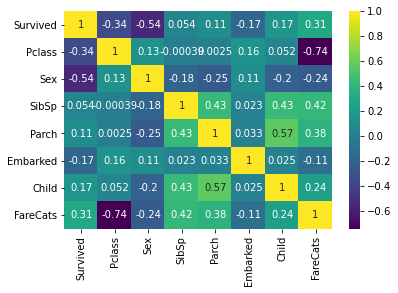

In [1254]:
sns.heatmap(train.drop(['PassengerId'], axis=1).corr(), cmap='viridis',annot = True)
plt.show()

There are correlations between the different values but nothing above 0.6. None of the featues will be dropped. 

# Machine Learning #

Features and target need to be split up.

In [1255]:
train_features = train.drop(['PassengerId', 'Survived'], axis=1)
train_target = train['Survived']
test_features = test.drop(['PassengerId'], axis=1)

RandomForestClassifier works well with categorical data. Therefore, it will be the first clssifier used. Cross validation will be used to 

In [1256]:
rf = RandomForestClassifier(random_state=0)
scores = cross_val_score(rf, train_features, train_target, cv=4)
print(scores)
print(np.mean(scores))

[0.82511211 0.86098655 0.8161435  0.81081081]
0.8282632408192947


In [1257]:
knn = KNeighborsClassifier()
scores = cross_val_score(knn, train_features, train_target, cv=4)
print(scores)
print(np.mean(scores))

[0.75784753 0.8206278  0.78923767 0.83783784]
0.8013877105805357


In [1258]:
gnb = GaussianNB()
scores = cross_val_score(gnb, train_features, train_target, cv=4)
print(scores)
print(np.mean(scores))

[0.68609865 0.79372197 0.77578475 0.7972973 ]
0.7632256696158042


# TO DO: #
- extratct what was the important parameters in random forest
- perform hyperparameter tuning of the 3 models

In [1259]:
train[adult_male_died].describe()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Embarked,Child,FareCats
count,451.000000,451.0,451.000000,451.0,451.000000,451.000000,451.000000,451.0,451.000000
mean,453.882483,0.0,2.456763,1.0,0.241685,0.150776,1.631929,0.0,3.492239
std,257.480126,0.0,0.768703,0.0,0.517808,0.489324,0.725565,0.0,2.785168
min,1.000000,0.0,1.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000
25%,222.500000,0.0,2.000000,1.0,0.000000,0.000000,2.000000,0.0,1.000000
50%,465.000000,0.0,3.000000,1.0,0.000000,0.000000,2.000000,0.0,3.000000
75%,680.000000,0.0,3.000000,1.0,0.000000,0.000000,2.000000,0.0,6.000000
max,891.000000,0.0,3.000000,1.0,2.000000,3.000000,2.000000,0.0,9.000000


In [1260]:
train[adult_male_survived].describe()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Embarked,Child,FareCats
count,86.000000,86.0,86.000000,86.0,86.000000,86.000000,86.000000,86.0,86.000000
mean,473.755814,1.0,1.930233,1.0,0.244186,0.104651,1.406977,0.0,5.127907
std,235.404530,0.0,0.955365,0.0,0.483518,0.376644,0.899384,0.0,2.909605
min,18.000000,1.0,1.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000
25%,284.750000,1.0,1.000000,1.0,0.000000,0.000000,0.000000,0.0,2.000000
50%,510.500000,1.0,2.000000,1.0,0.000000,0.000000,2.000000,0.0,6.000000
75%,657.750000,1.0,3.000000,1.0,0.000000,0.000000,2.000000,0.0,8.000000
max,890.000000,1.0,3.000000,1.0,2.000000,2.000000,2.000000,0.0,9.000000


In [1261]:
stupid_est = train['Child'] | ~ train['Sex'].astype('bool')
results = train['Survived'].astype('bool') & stupid_est
print(results.sum() / train['Survived'].sum())

print(train[train['Survived'].astype('bool') & ~ stupid_est])

0.7485380116959064
     PassengerId  Survived  Pclass  Sex  SibSp  Parch  Embarked  Child  \
17            18         1       2    1      0      0         2      0   
21            22         1       2    1      0      0         2      0   
23            24         1       1    1      0      0         2      0   
36            37         1       3    1      0      0         0      0   
55            56         1       1    1      0      0         2      0   
..           ...       ...     ...  ...    ...    ...       ...    ...   
828          829         1       3    1      0      0         1      0   
838          839         1       3    1      0      0         2      0   
839          840         1       1    1      0      0         0      0   
857          858         1       1    1      0      0         2      0   
889          890         1       1    1      0      0         0      0   

     FareCats  
17          4  
21          4  
23          7  
36          0  
55          

Feature Selection

In [1262]:
correlation_matrix_male_survived = pd.crosstab(train['Survived'], train['Sex'], 
                                               rownames=['Survived'], colnames=['Sex'])
print(correlation_matrix_male_survived)
print(train.groupby('Sex')['Survived'].agg(np.mean))
#Male is a good feature

Sex         0    1
Survived          
0          81  468
1         233  109
Sex
0    0.742038
1    0.188908
Name: Survived, dtype: float64


In [1263]:
correlation_matrix_pclass_survived = pd.crosstab(train['Survived'], train['Pclass'], 
                                                 rownames=['Survived'], colnames=['Pclass'])
print(correlation_matrix_pclass_survived)
print(train.groupby('Pclass')['Survived'].agg(np.mean))
#Pclass is a good feature

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


In [1264]:
print(train.groupby('Embarked')['Survived'].agg([np.mean, 'count']))

              mean  count
Embarked                 
0         0.553571    168
1         0.389610     77
2         0.339009    646


In [1265]:
print(train.groupby('SibSp')['Survived'].agg([np.mean, 'count']))

           mean  count
SibSp                 
0      0.345395    608
1      0.535885    209
2      0.270270     74


In [1266]:
print(train.groupby('Parch')['Survived'].agg(np.mean))
print(train.groupby('Parch')['Survived'].count())

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.266667
Name: Survived, dtype: float64
Parch
0    678
1    118
2     80
3     15
Name: Survived, dtype: int64


In [1267]:
print(train.groupby('Embarked')['Survived'].agg(np.mean))
print(train.groupby('Embarked')['Survived'].count())
# suprisingly this looks like a good feature

Embarked
0    0.553571
1    0.389610
2    0.339009
Name: Survived, dtype: float64
Embarked
0    168
1     77
2    646
Name: Survived, dtype: int64


In [1268]:
def most_frequent(input_list):
    if not input_list:
        return ''
    else:
        occurence_count = Counter(input_list)
        return occurence_count.most_common(1)[0][0] 